In [3]:
# !ls data

# !pip install pandas

# !pip install chardet

# !pip install transformers

# !pip install seaborn

# !pip install statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
import re
import transformers
import pandas as pd
import chardet
import numpy as np
import os
from transformers import BertModel, BertTokenizer
import torch
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics.pairwise import cosine_similarity

c:\Users\batik\miniconda3\envs\0General\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
result_df_loaded = pd.read_pickle('result_df_clean.pkl')
result_df_loaded.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35163 entries, 2020-10-19 to 2024-04-02
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   KREIS                 35163 non-null  category      
 1   GEMEINDE              35163 non-null  category      
 2   TYP                   35163 non-null  category      
 3   HERSTELLER            35163 non-null  category      
 4   NABENHOEHE            35120 non-null  float64       
 5   ROTORDURCHMESSER      35119 non-null  float64       
 6   SCHALLLEISTUNGSPEGEL  35163 non-null  float64       
 7   LEISTUNG              35162 non-null  float64       
 8   LEISTUNGSBEZUG        35163 non-null  category      
 9   OSTWERT               35163 non-null  float64       
 10  NORDWERT              35163 non-null  float64       
 11  GENEHMIGT_AM          33085 non-null  datetime64[ns]
 12  INBETRIEBNAHME        29924 non-null  datetime64[ns]
 13 

In [5]:
result_df_loaded

,KREIS,GEMEINDE,TYP,HERSTELLER,NABENHOEHE,ROTORDURCHMESSER,SCHALLLEISTUNGSPEGEL,LEISTUNG,LEISTUNGSBEZUG,OSTWERT,NORDWERT,GENEHMIGT_AM,INBETRIEBNAHME,STATUS,BST_NR,ANL_NR,DATENQUELLE,AKTENZEICHEN
DATENDATUM,,,,,,,,,,,,,,,,,,
2020-10-19,Lübeck,Lübeck,enercon e 82 e,Enercon,85.0,82.0,1045.0,2300.0,kW Nennleist. Rotor.,32619817.0,5978875.0,2011-01-04,2012-09-25,in Betrieb,3000924205,1,"LLUR SH, Abtl. 7",NaN
2020-10-19,Lübeck,Lübeck,enercon e 82 e,Enercon,85.0,82.0,1045.0,2300.0,kW Nennleist. Rotor.,32619815.0,5977994.0,2011-01-04,2012-09-25,in Betrieb,3000924205,2,"LLUR SH, Abtl. 7",NaN
2020-10-19,Lübeck,Lübeck,tacke tw 600,Tacke,50.0,43.0,983.0,600.0,kW Nennleist. Rotor.,32620847.0,5977577.0,1996-04-16,1996-04-10,in Betrieb,3000924233,1,"LLUR SH, Abtl. 7",NaN
2020-10-19,Dithmarschen,Albersdorf,vestas v112,Vestas,119.0,112.0,1065.0,3300.0,kW Nennleist. Rotor.,32516648.0,5999295.0,2013-07-10,2014-11-06,in Betrieb,51001900011,1,"LLUR SH, Abtl. 7",NaN
2020-10-19,Dithmarschen,Albersdorf,vestas v112,Vestas,119.0,112.0,1065.0,3300.0,kW Nennleist. Rotor.,32516599.0,5998975.0,2013-07-10,2014-11-06,in Betrieb,51001900011,2,"LLUR SH, Abtl. 7",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-02,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500.0,kW Nennleist. Rotor.,593273.0,5969688.0,2002-08-14,2002-01-12,in Betrieb,62093445249,2,"LfU SH, Abtl. 7",G30/028/2001-L108
2024-04-02,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500.0,kW Nennleist. Rotor.,593509.0,5969619.0,2002-08-14,2002-01-12,in Betrieb,62093445249,3,"LfU SH, Abtl. 7",G30/028/2001-L108
2024-04-02,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500.0,kW Nennleist. Rotor.,594038.0,5969465.0,2002-08-14,2002-01-12,in Betrieb,62093445249,4,"LfU SH, Abtl. 7",G30/028/2001-L108


In [6]:
# !pip install geopandas
# !pip install folium

import geopandas as gpd
import folium
import pandas as pd
from shapely.geometry import Point


In [13]:
import pandas as pd

# Assuming df is your DataFrame
# First, you would load your data into the DataFrame
# df = pd.read_csv('your_file.csv')  # Example for loading data from a CSV file

# Drop duplicates based on the 'OSTWERT' and 'NORDWERT' columns to find unique wind turbines
unique_turbines = result_df_loaded.drop_duplicates(subset=['OSTWERT', 'NORDWERT'])

# Count the number of unique wind turbines
num_unique_turbines = len(unique_turbines)
print(f"There are {num_unique_turbines} unique wind turbines in the dataset.")


There are 7939 unique wind turbines in the dataset.


In [7]:
result_df_loaded.index['DATENDATUM']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

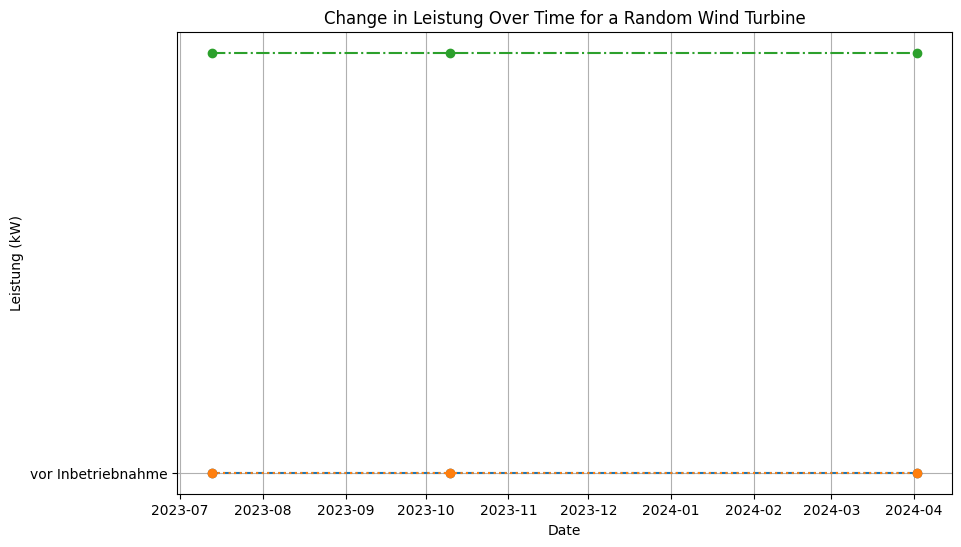

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame containing the wind turbine data

# Select a random pair of 'OSTWERT' and 'NORDWERT'
unique_pairs = result_df_loaded.drop_duplicates(subset=['OSTWERT', 'NORDWERT'])
random_pair = unique_pairs.sample(n=1)

# Filter the original DataFrame to include only the randomly selected turbine
filtered_df = result_df_loaded[(result_df_loaded['OSTWERT'] == random_pair['OSTWERT'].values[0]) & 
                 (result_df_loaded['NORDWERT'] == random_pair['NORDWERT'].values[0])]

# Plotting the 'LEISTUNG' over time for the selected turbine
plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index, filtered_df['LEISTUNG'], marker='o', linestyle='dashed')
plt.plot(filtered_df.index, filtered_df['STATUS'], marker='o', linestyle='dotted')
plt.plot(filtered_df.index, filtered_df['SCHALLLEISTUNGSPEGEL'], marker='o', linestyle='dashdot')



plt.title('Change in Leistung Over Time for a Random Wind Turbine')
plt.xlabel('Date')
plt.ylabel('Leistung (kW)')
plt.grid(True)
plt.show()


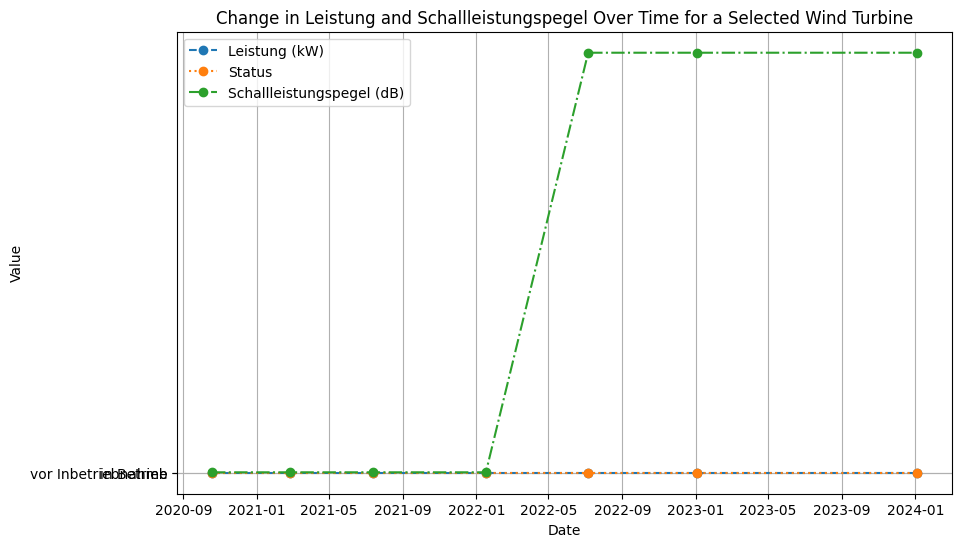

In [73]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame containing the wind turbine data

# Identify turbines where 'SCHALLLEISTUNGSPEGEL' changes
# Group by 'OSTWERT' and 'NORDWERT' and filter groups where 'SCHALLLEISTUNGSPEGEL' has more than one unique value
grouped = result_df_loaded.groupby(['OSTWERT', 'NORDWERT'])
filtered_groups = grouped.filter(lambda x: x['SCHALLLEISTUNGSPEGEL'].nunique() > 1)

# Select one of these turbines randomly
if not filtered_groups.empty:
    random_pair = filtered_groups.sample(n=1)[['OSTWERT', 'NORDWERT']].iloc[0]
    filtered_df = result_df_loaded[(result_df_loaded['OSTWERT'] == random_pair['OSTWERT']) & 
                     (result_df_loaded['NORDWERT'] == random_pair['NORDWERT'])]

    # Plotting the 'LEISTUNG', 'STATUS', and 'SCHALLLEISTUNGSPEGEL' over time for the selected turbine
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df.index, filtered_df['LEISTUNG'], marker='o', linestyle='dashed', label='Leistung (kW)')
    plt.plot(filtered_df.index, filtered_df['STATUS'], marker='o', linestyle='dotted', label='Status')
    plt.plot(filtered_df.index, filtered_df['SCHALLLEISTUNGSPEGEL'], marker='o', linestyle='dashdot', label='Schallleistungspegel (dB)')

    plt.title('Change in Leistung and Schallleistungspegel Over Time for a Selected Wind Turbine')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No turbines were found with changes in Schallleistungspegel.")


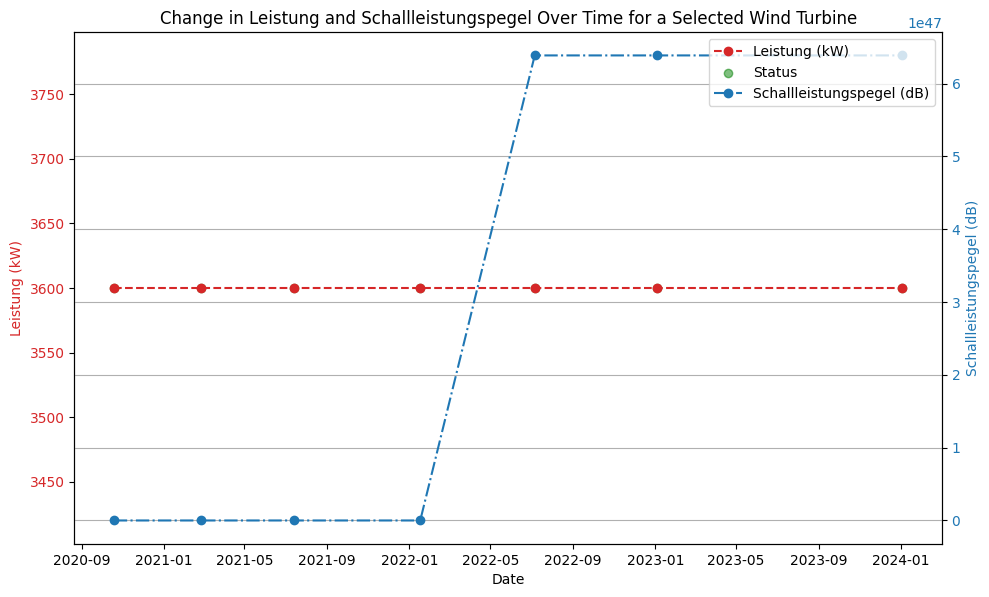

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame containing the wind turbine data

# Identify turbines where 'SCHALLLEISTUNGSPEGEL' changes
# Group by 'OSTWERT' and 'NORDWERT' and filter groups where 'SCHALLLEISTUNGSPEGEL' has more than one unique value
grouped = result_df_loaded.groupby(['OSTWERT', 'NORDWERT'])
filtered_groups = grouped.filter(lambda x: x['SCHALLLEISTUNGSPEGEL'].nunique() > 1)

# Select one of these turbines randomly
if not filtered_groups.empty:
    random_pair = filtered_groups.sample(n=1)[['OSTWERT', 'NORDWERT']].iloc[0]
    filtered_df = result_df_loaded[(result_df_loaded['OSTWERT'] == random_pair['OSTWERT']) & 
                     (result_df_loaded['NORDWERT'] == random_pair['NORDWERT'])]

    # Create a plot with a secondary y-axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot 'LEISTUNG' and 'SCHALLLEISTUNGSPEGEL' on primary y-axis
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Leistung (kW)', color=color)
    ax1.plot(filtered_df.index, filtered_df['LEISTUNG'], color=color, marker='o', linestyle='dashed', label='Leistung (kW)')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Schallleistungspegel (dB)', color=color)  # we already handled the x-label with ax1
    ax2.plot(filtered_df.index, filtered_df['SCHALLLEISTUNGSPEGEL'], color=color, marker='o', linestyle='dashdot', label='Schallleistungspegel (dB)')
    ax2.tick_params(axis='y', labelcolor=color)

    # Plot 'STATUS' using a scatter plot on primary y-axis
    ax1.scatter(filtered_df.index, [filtered_df['LEISTUNG'].max()] * len(filtered_df), c='green', label='Status', alpha=0.5)  # Plot as dots at the top

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Change in Leistung and Schallleistungspegel Over Time for a Selected Wind Turbine')
    fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.grid(True)
    plt.show()
else:
    print("No turbines were found with changes in Schallleistungspegel.")


In [79]:
import numpy as np
import random

# Parameters
alpha = 0.1      # learning rate
gamma = 0.6      # discount factor
epsilon = 0.1    # exploration-exploitation tradeoff
num_episodes = 10000

# Initialize Q-table
q_table = np.zeros((2, 2))

# Environment simulation
def step(state, action):
    if action == 1:  # perform maintenance
        return 0, -3  # always returns to normal operation
    elif state == 0:  # normal operation, do nothing
        if np.random.random() < 0.05:  # 5% chance of failure
            return 1, -10  # moves to faulty state
        else:
            return 0, 1  # stays in normal operation
    elif state == 1:  # faulty operation, do nothing
        return 1, -10  # stays in faulty state

# Q-learning algorithm
for episode in range(num_episodes):
    state = 0  # start from normal operation
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = random.choice([0, 1])  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values

        next_state, reward = step(state, action)
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        # Update Q-value
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        state = next_state

        if episode % 1000 == 0:
            print(f"Episode {episode}, State: {state}, Action: {action}, Reward: {reward}")

print("Training finished.\n")

print(q_table)
